In [414]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [415]:
_time_intervals = 30  # Number of time intervals in a planning horizon
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios
M = 1e3  # Big M

init = [1]

varying_list = [1.00, 0.53, 0.58, 0.53, 0.65, 0.73] + [1.75, 1.74, 1.72, 1.72, 1.79, 1.80]

varying_list = [i for i in varying_list for j in range(_time_intervals)]

demand_factor = pandas.DataFrame(data={'com1_sold': varying_list})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.58, 0.54, 0.07, 0.69, 0.17, 0.53, 0.35, 0.48, 0.39, 0.51, 0.38]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.26, 0.66, 0.28, 0.65, 0.01, 0.49, 0.39, 0.61, 0.44, 0.3, 0.68]})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1]*_exec_scenarios})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1]*_exec_scenarios})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})

# Define temporal scales
scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])

In [416]:
# pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0.5, 1.0), 2) for _ in range(_exec_scenarios-1)]})

In [417]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=80, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system', varying=[VaryingResource.DETERMINISTIC_DEMAND])

In [418]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=80, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.01, prod_min=80,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.01, prod_min=M,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=200, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=200, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=200, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=200, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=200, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=200, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=200, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 7')
com1_process = Process(name='com1_process', prod_max=200, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=150, capex=100, vopex=0.01, store_min=0, store_max= 10, prod_min=150,
                  label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.001)

com1_store20 = Process(name='com1_store20', prod_max=150, capex=200, vopex=0.01, store_min=0,store_max= 20, prod_min=150,
                  label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.002)

com1_store50 = Process(name='com1_store50', prod_max=150, capex=500, vopex=0.01, store_min=0, store_max= 50, prod_min=150,
                  label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.005)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=200, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=200, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=200, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=200, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=200, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=200, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=200, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 7')

In [419]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, demand_factor={com1_sold: demand_factor[['com1_sold']]})

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

# loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store10, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0, availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})
# 
# loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store10, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store10, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store10, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store20, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0, availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})
# 
# loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)

In [420]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=70, label='Truck capacity of 50 units from location 1 to 2', capex=0.5, vopex=0.05, trans_min=70)
truck50_21 = Transport(name='truck50_21', resources={com1_loc2_out}, trans_max=70, label='Truck capacity of 50 units from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=70)

truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=50, label='Truck capacity of 30 units from location 1 to 3', capex=0.3, vopex=0.03, trans_min=50)
truck30_31 = Transport(name='truck30_31', resources={com1_loc3_out}, trans_max=50, label='Truck capacity of 30 units from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=50)

truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=100, label='Truck capacity of 50 units from location 2 to 4', capex=0.5, vopex=0.05, trans_min=100)
truck50_42 = Transport(name='truck50_42', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 50 units from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=100)

truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=70, label='Truck capacity of 30 units from location 2 to 5', capex=0.3, vopex=0.03, trans_min=70)
truck30_52 = Transport(name='truck30_52', resources={com1_loc5_out}, trans_max=70, label='Truck capacity of 30 units from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=70)

truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=50, label='Truck capacity of 20 units from location 3 to 4', capex=0.2, vopex=0.02, trans_min=50)
truck20_43 = Transport(name='truck20_43', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 20 units from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=50)

truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 100 units from location 4 to 5', capex=1, vopex=0.01, trans_min=100)
truck100_54 = Transport(name='truck100_54', resources={com1_loc5_out}, trans_max=100, label='Truck capacity of 100 units from location 5 to 4', capex=0.0001, vopex=0.01, trans_min=100)

truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 40 units from location 4 to 7', capex=0.4, vopex=0.04, trans_min=50)
truck40_74 = Transport(name='truck40_74', resources={com1_loc7_out}, trans_max=50, label='Truck capacity of 40 units from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=50)

truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=100, label='Truck capacity of 50 units from location 6 to 4', capex=0.5, vopex=0.05, trans_min=100)
truck50_46 = Transport(name='truck50_46', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 50 units from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=100)

truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=50, label='Truck capacity of 40 units from location 7 to 5', capex=0.4, vopex=0.04, trans_min=50)
truck40_57 = Transport(name='truck40_57', resources={com1_loc5_out}, trans_max=50, label='Truck capacity of 40 units from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=50)

In [421]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
    [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [422]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty = 50000
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_res_baseline = Scenario(name='scenario_res_baseline', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=0, demand_scale_level=1, capacity_scale_level=0,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Baseline scenario for information sharing with resource variability', annualization_factor=(1/12))

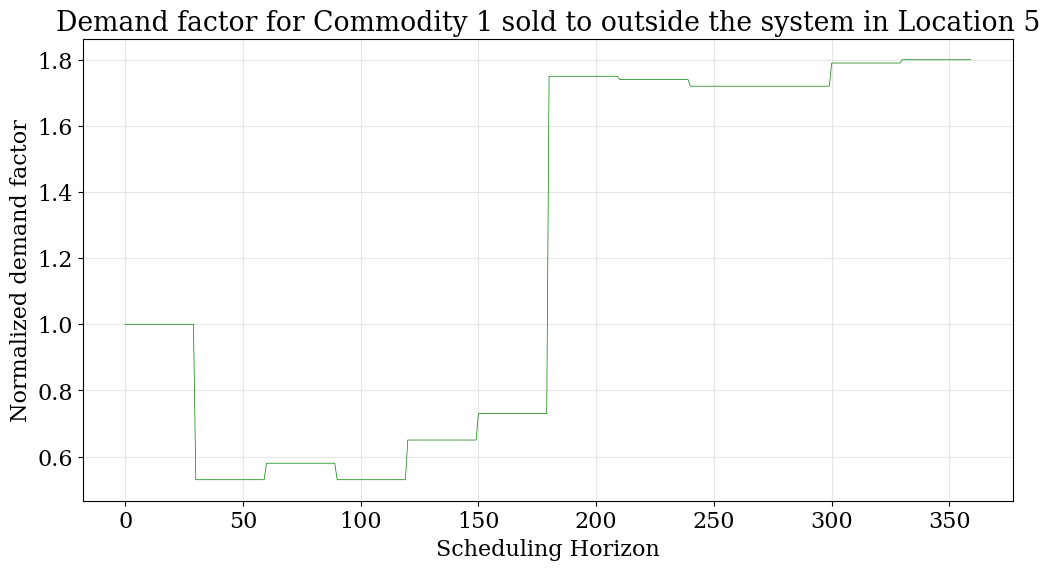

In [423]:
plot_scenario.demand_factor(scenario=scenario_res_baseline, resource=com1_sold, location=loc5, color='green')

In [424]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# 
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
# rc('text', usetex=False)
# 
# fig, ax = plt.subplots()
# 
# # Plot data from the first dataset
# ax.plot(range(len(scenario_res_baseline.availability_factor['loc1']['com1_pur'].values())), scenario_res_baseline.availability_factor['loc1']['com1_pur'].values(), label='Location 1',
#         color='blue', marker='o')
# 
# ax.plot(range(len(scenario_res_baseline.availability_factor['loc6']['com1_pur'].values())), scenario_res_baseline.availability_factor['loc6']['com1_pur'].values(), label='Location 6',
#         color='red', marker='x')
# # Customize the plot
# ax.set_xlabel('Time Horizon')
# ax.set_ylabel('Normalized Availability Factor')
# ax.set_title('Resource Availability factor')
# ax.legend()
# ax.plot(linewidth=0.5)
# plt.grid(alpha=0.3)
# plt.rcdefaults()
# # Show the plot
# plt.show()

In [425]:
# problem_mincost.constraint_demand_penalty.pprint()

In [426]:
problem_mincost = formulate(scenario=scenario_res_baseline,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint demand penalty
objective cost w demand penalty


In [427]:
results_mincost = solve(scenario=scenario_res_baseline, instance=problem_mincost, solver='gurobi', name='scenario_res_baseline', saveformat = '.pkl')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1003956 rows, 2866381 columns and 1392507 nonzeros
Model fingerprint: 0x88d998d3
Coefficient statistics:
  Matrix range     [5e-04, 4e+01]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 997836 rows and 2850188 columns
Presolve time: 0.70s
Presolved: 6120 rows, 16193 columns, 31299 nonzeros
Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.223e+04
 Factor NZ  : 8.846e+04 (roughly 10 MB of memory)
 Factor Ops : 1.341e+06 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0

In [428]:
# problem_mincost.objective_cost_w_demand_penalty.pprint()

In [429]:
total_cost = sum(value for key, value in results_mincost.output['Capex_network'].items()) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Inv_cost'].items()) +\
sum(value for key, value in results_mincost.output['Demand_penalty'].items())*demand_penalty

total_cost

129090626.674

In [430]:
# sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') / (100*_exec_scenarios*_time_intervals)

In [431]:
# min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

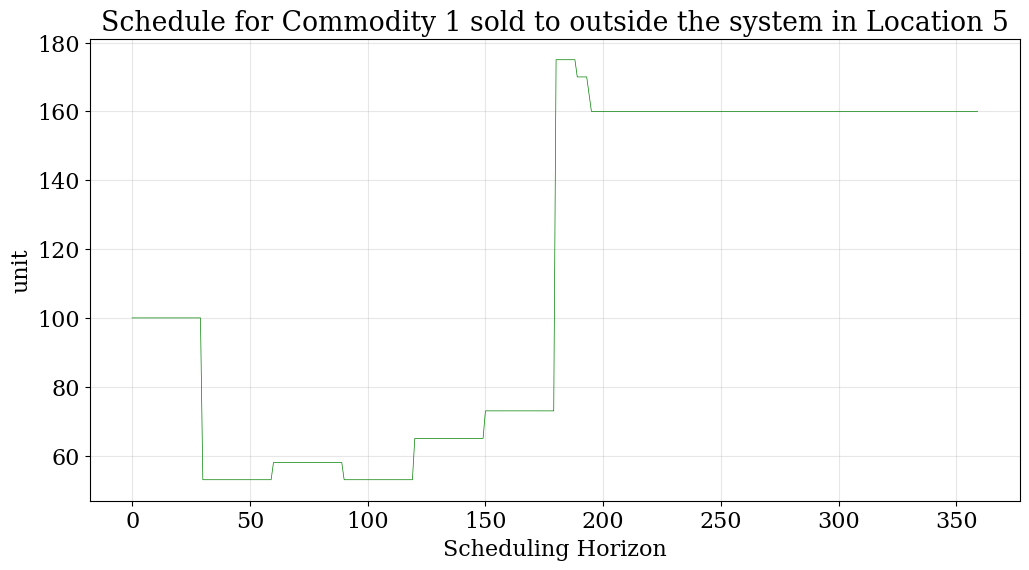

In [432]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [433]:
# problem_maxd = formulate(scenario=scenario_res_baseline,
#                             constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
#                                          Constraints.INVENTORY, Constraints.PRODUCTION},
#                             demand_sign='eq', objective=Objective.MAX_DISCHARGE,objective_resource=com1_sold)

In [434]:
# results_maxd = solve(scenario=scenario_res_baseline, instance=problem_maxd, solver='gurobi', name='MILP')

In [435]:
# total_cost = sum(value for key, value in results_maxd.output['Capex_network'].items()) + \
# sum(value for key, value in results_maxd.output['Capex_transport_network'].items()) + \
# sum(value for key, value in results_maxd.output['Vopex_network'].items()) + \
# sum(value for key, value in results_maxd.output['Vopex_transport_network'].items()) + \
# sum(value for key, value in results_maxd.output['Inv_cost'].items())
# 
# total_cost

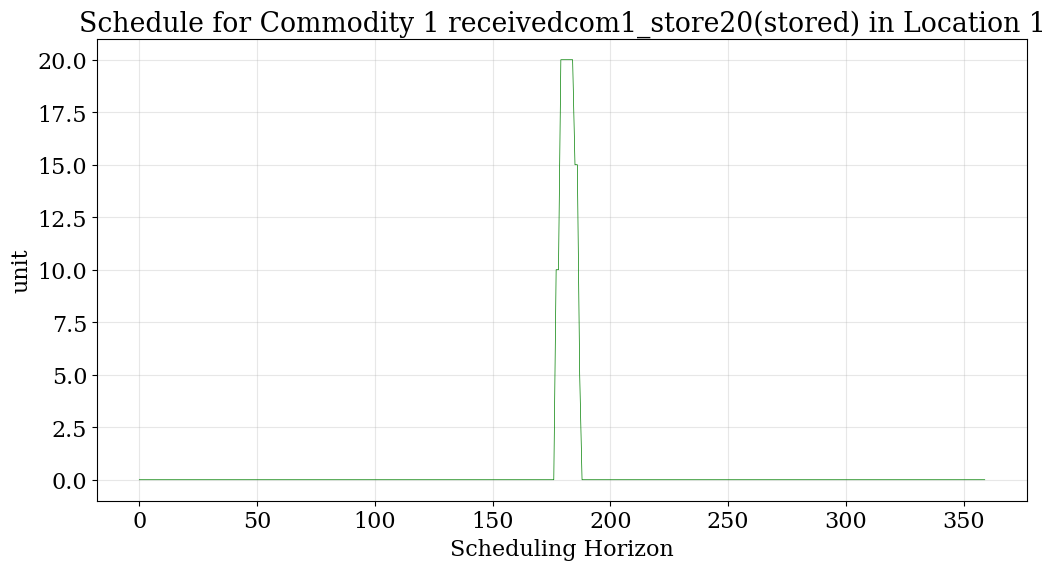

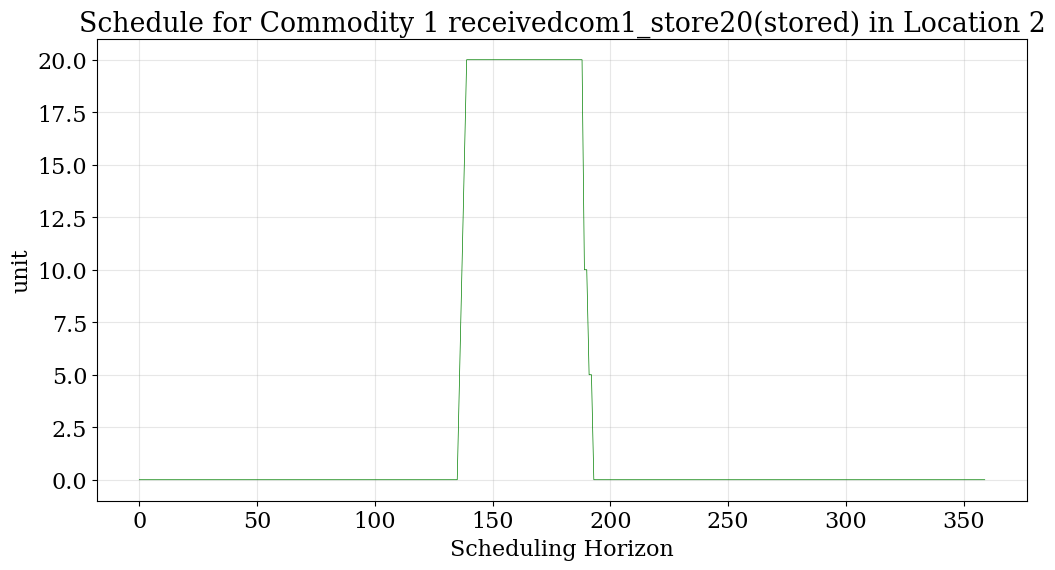

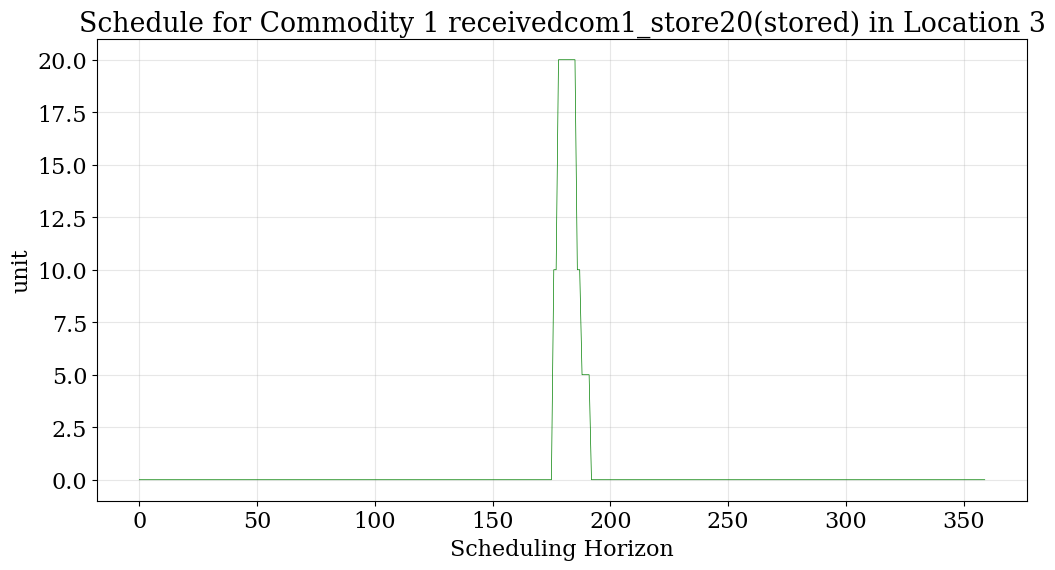

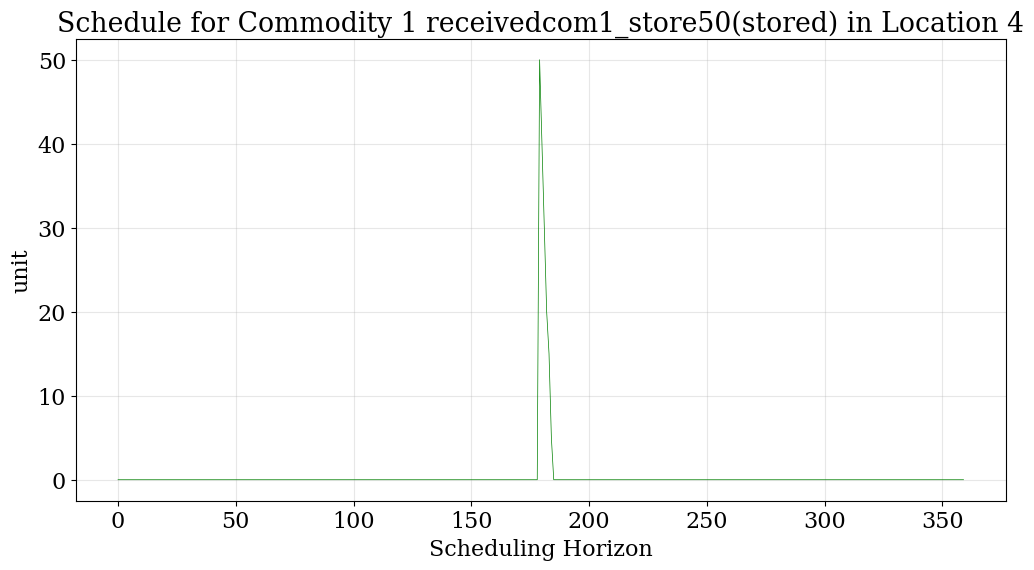

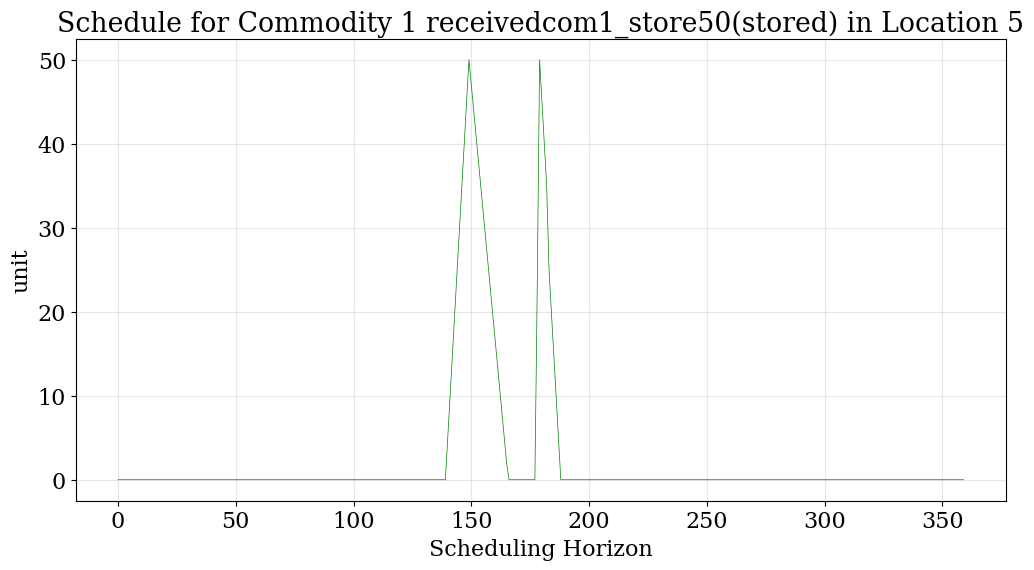

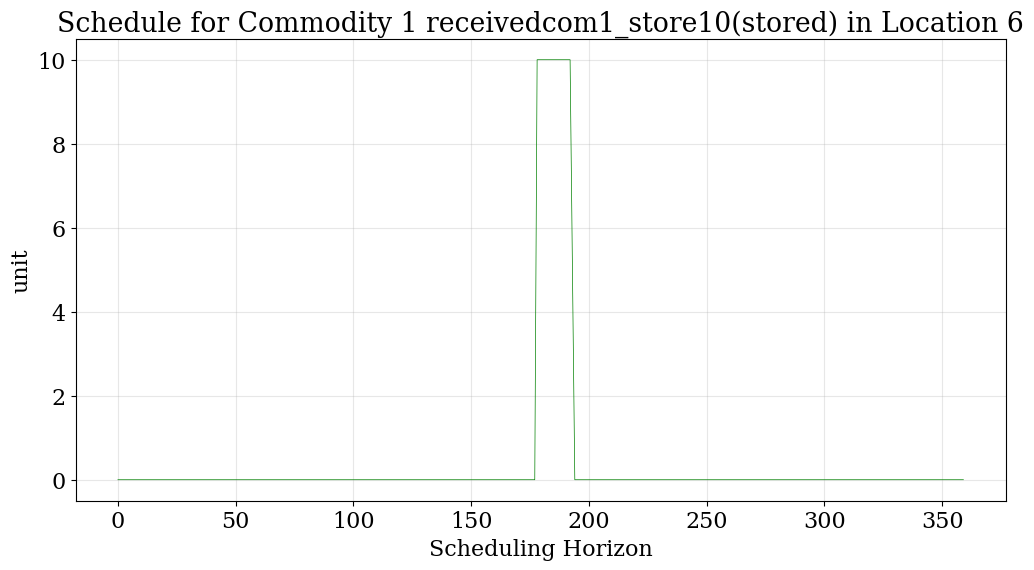

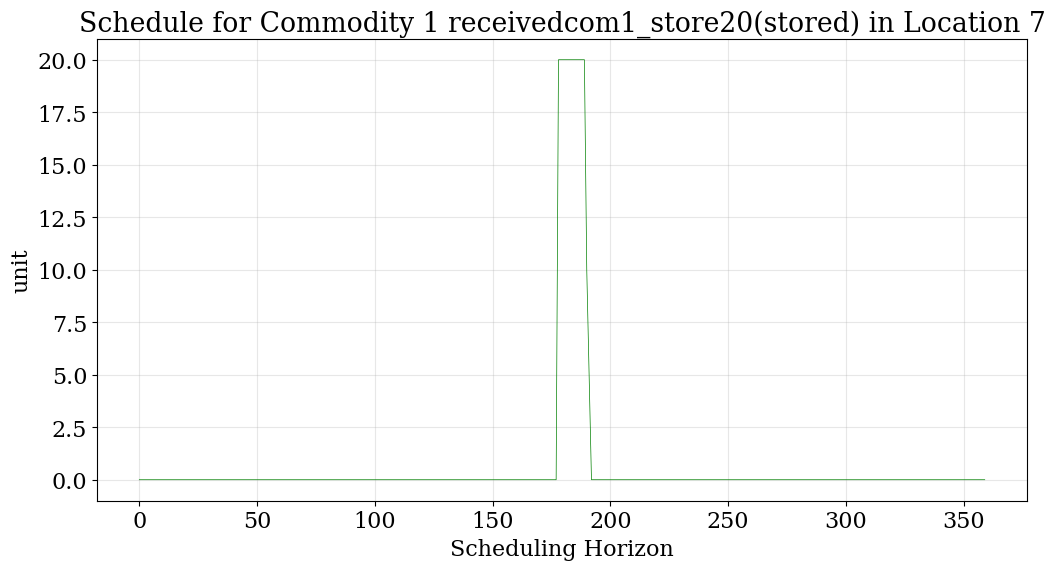

In [436]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc1', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc2', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc3', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc4', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc5', color='green')

In [437]:
# plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
#                        resource='com1_loc1_out')
# plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
#                        resource='com1_loc1_out')
# plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck50_24',
#                        resource='com1_loc2_out')
# plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
#                        resource='com1_loc2_out')
# plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
#                        resource='com1_loc3_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
#                        resource='com1_loc6_out')
# plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
#                        resource='com1_loc7_out')

In [438]:
# plot_results.transport(results=results_mincost, source='loc2', sink='loc1', transport='truck50_21',
#                        resource='com1_loc2_out')
# plot_results.transport(results=results_mincost, source='loc3', sink='loc1', transport='truck30_31',
#                        resource='com1_loc3_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc2', transport='truck50_42',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc5', sink='loc2', transport='truck30_52',
#                        resource='com1_loc5_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc3', transport='truck20_43',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc5', sink='loc4', transport='truck100_54',
#                        resource='com1_loc5_out')
# plot_results.transport(results=results_mincost, source='loc7', sink='loc4', transport='truck40_74',
#                        resource='com1_loc7_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc6', transport='truck50_46',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc5', sink='loc7', transport='truck40_57',
#                        resource='com1_loc5_out')

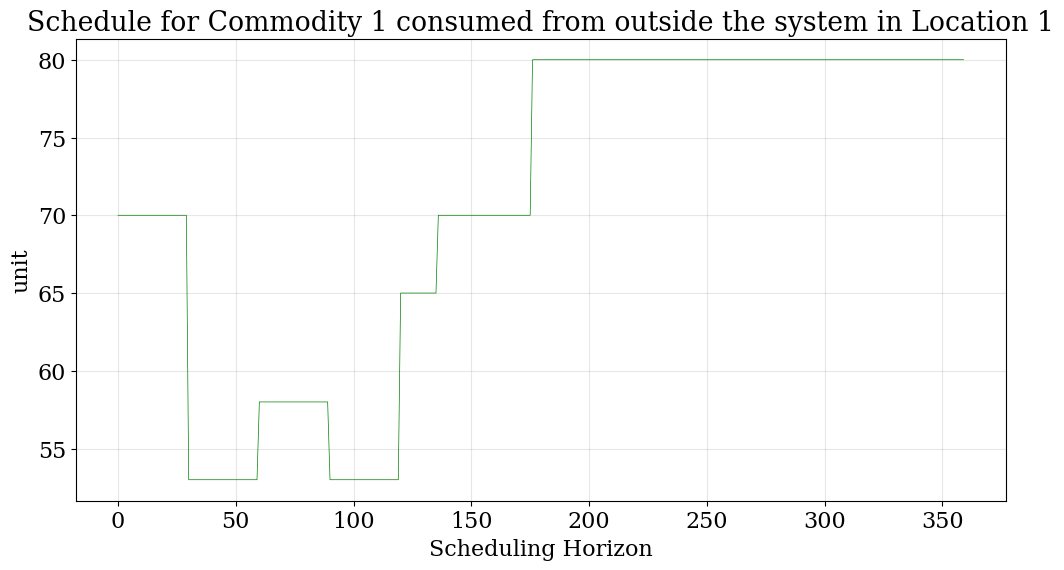

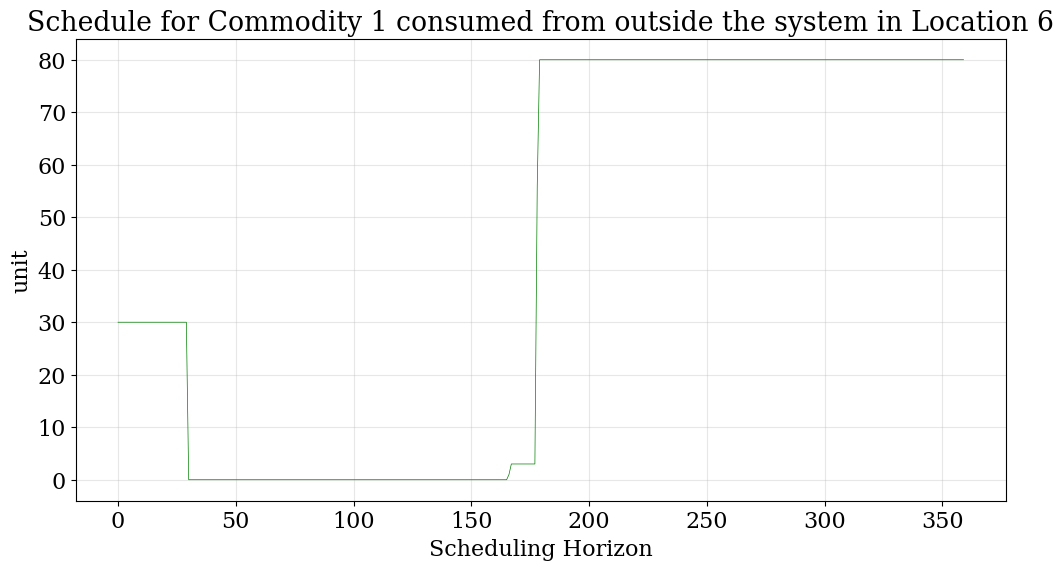

In [439]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

In [440]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()

Capex_network : Capex at network scale
    Size=12, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      1 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      2 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      3 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      4 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      5 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      6 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      7 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      8 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
      9 :     0 : 23812.999999999996 :  None : False : False : NonNegativeReals
     10 :     0 : 23812.999999999996 :  None : False : Fa

In [441]:
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()

Capex_transport_network : overall capex for transport at the network level
    Size=12, Index=scales_network
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      1 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      2 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      3 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      4 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      5 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      6 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      7 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      8 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
      9 :     0 : 2982.860333333333 :  None : False : False : NonNegativeReals
     10 :     0 : 2982.860333333

In [442]:
results_mincost.output[('objective')]

129090626.674

In [443]:
total_cost = sum(value for key, value in results_mincost.output['Capex_network'].items()) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items())*demand_penalty +\
sum(value for key, value in results_mincost.output['Inv_cost'].items())

total_cost

129090626.674

In [444]:
inventory1 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 1, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 1, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 1, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 1, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 1, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 1, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 1, 0)]}
                  }
inventory1

# inventory1 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 1, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 1, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 1, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 1, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 1, 0)]},
#                   }
# inventory1

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [445]:
cost1 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=0)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]<=0)

cost1

46016.86033333333

In [446]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold' and key[2]<=0)

3000.0

In [447]:
inventory2 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 2, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 2, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 2, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 2, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 2, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 2, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 2, 0)]}
                  }
inventory2

# inventory2 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 2, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 2, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 2, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 2, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 2, 0)]},
#                   }
# inventory2

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [448]:
cost2 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=1)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]<=1)

cost2

82670.72066666666

In [449]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold' and key[2]<=1)

4590.0

In [450]:
161144.44075 - 103170.05383333334

57974.38691666667

In [451]:
cost_test = sum(value for key, value in results_mincost.output['Capex_network'].items() if key==2) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key==2) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key==2) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key==2) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]==2)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]==2)

cost_test

37583.86033333333

In [452]:
inventory3 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 3, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 3, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 3, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 3, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 3, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 3, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 3, 0)]}
                  }
inventory3

# inventory3 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 3, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 3, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 3, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 3, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 3, 0)]},
#                   }
# inventory3

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [453]:
cost3 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=2)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]<=2)

cost3

120254.58099999998

In [454]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold' and key[2]<=2)

6330.0

In [455]:
inventory4 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 4, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 4, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 4, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 4, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 4, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 4, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 4, 0)]}
                  }
inventory4

# inventory4 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 4, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 4, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 4, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 4, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 4, 0)]},
#                   }
# inventory4

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [456]:
cost4 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=3)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]<=3)

cost4

156908.44133333332

In [457]:
# cost4_vopex = sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=3) + \
# sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=3) + \
# sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=3)*demand_penalty
# 
# cost4_vopex

In [458]:
# sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold' and key[2]<=3)

In [459]:
# sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=3)

In [460]:
# sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=3)

In [461]:
# sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=3)*demand_penalty

In [462]:
inventory5 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 5, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 5, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 5, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 5, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 5, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 5, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 5, 0)]}
                  }
inventory5

# inventory5 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 5, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 5, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 5, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 5, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 5, 0)]},
#                   }
# inventory5

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 47.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [463]:
cost5 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=4)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]<=4)


cost5

196161.67666666664

In [464]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold' and key[2]<=4)

9870.0

In [465]:
inventory6 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 6, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 6, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 6, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 6, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 6, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 6, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 6, 0)]}
                  }
inventory6

# inventory6 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 6, 0)]},
#                   }
# inventory6

{loc1: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 40.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 45.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 10.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 20.0}}

In [466]:
cost6 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=5)*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items() if key[2]<=5)

cost6

237205.412

In [467]:
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=5)

1096.6000000000001

In [468]:
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=5)

75327.70000000001

In [469]:
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=5)*demand_penalty

0.0

In [470]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold' and key[2]<=5)

12060.0

In [471]:
cost_res = sum(value for key, value in results_mincost.output['Capex_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]>=6)*demand_penalty

cost_res

128853418.162

In [472]:
cost = sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=5)*demand_penalty

cost

76424.30000000002